# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import ConstantPopulationSize, AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           plot_parameter_sensitivity,
                           plot_parameters_kde,
                           plot_distance_weights)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create the ion channel model

In [5]:
from channels.ik1 import ik1 as model
#model.sample({})

# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Normalise as conductance is not fit in this notebook
obs = {k: v / abs(max(obs.values(), key=abs)) for k, v in obs.items()}

In [29]:
measurements['y'] = obs.values()

# Set limits and generate uniform initial priors

In [7]:
limits = dict(k_1=(-1000, 1000),
              k_2=(0, 100),
              k_3=(0, 1),
              k_4=(0, 0.1))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [8]:
parameters = ['ik1.'+k for k in limits.keys()]

In [9]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

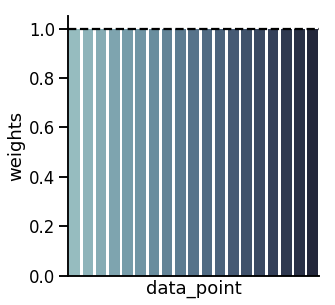

In [10]:
sns.set_context('talk')
g = plot_distance_weights(model, distance_fn)
g.savefig('results/ik1/dist_weights.pdf')

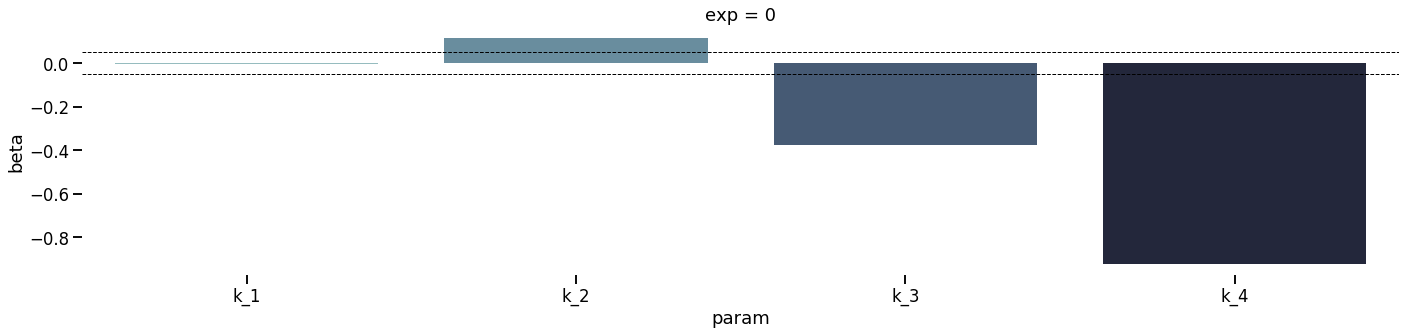

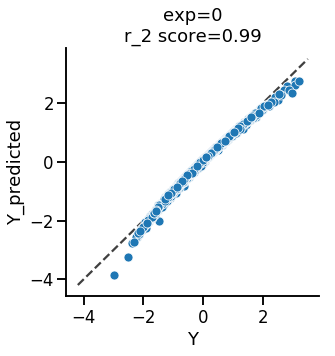

In [12]:
grid1, grid2 = plot_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=1000,
    plot_cutoff=0.05)

In [13]:
grid1.savefig('results/ik1/sensitivity.pdf')
grid2.savefig('results/ik1/sensitivity_fit.pdf')

In [14]:
# Update limits from study
limits = dict(k_2=(0, 100),
              k_3=(0, 1),
              k_4=(0, 0.1))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Define ABC parameters and initialise database

In [15]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ik1.db"))
print(db_path)

sqlite:////var/folders/18/lbp63zt51g90fcjs73tbh1x80000gn/T/hl-1_ik1.db


In [16]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [17]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             #population_size=ConstantPopulationSize(
             #    nr_particles=10000),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=5000,
                 mean_cv=0.2,
                 max_population_size=5000,
                 min_population_size=2500),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=1),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 1.0000000000000002, 1: 1.0000000000000002, 2: 1.0000000000000002, 3: 1.0000000000000002, 4: 1.0000000000000002, 5: 1.0000000000000002, 6: 1.0000000000000002, 7: 1.0000000000000002, 8: 1.0000000000000002, 9: 1.0000000000000002, 10: 1.0000000000000002, 11: 1.0000000000000002, 12: 1.0000000000000002, 13: 1.0000000000000002, 14: 1.0000000000000002, 15: 1.0000000000000002, 16: 1.0000000000000002, 17: 1.0000000000000002, 18: 1.0000000000000002}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [18]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-09-11 11:30:59.780491, end_time=None)>
/Users/charles/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/Users/charles/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
INFO:Epsilon:initial epsilon is 0.5793157463461251


In [19]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:0.5793157463461251
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 10136
/Users/charles/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/Users/charles/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
DEBUG:Epsilon:new eps, t=1, eps=0.269629969974653
INFO:ABC:t:1 eps:0.269629969974653
/Users/charles/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/Users/charles/miniconda3/envs/ionchannelABC/lib/python3.6/site-packag

DEBUG:ABC:population 27 done
DEBUG:ABC:
total nr simulations up to t =27 is 148449
DEBUG:Epsilon:new eps, t=28, eps=0.052298111669235016
INFO:ABC:t:28 eps:0.052298111669235016
INFO:Adaptation:Change nr particles 2500 -> 2500
DEBUG:ABC:now submitting population 28
DEBUG:ABC:population 28 done
DEBUG:ABC:
total nr simulations up to t =28 is 153686
DEBUG:Epsilon:new eps, t=29, eps=0.05229771059485619
INFO:ABC:t:29 eps:0.05229771059485619
INFO:Adaptation:Change nr particles 2500 -> 2500
DEBUG:ABC:now submitting population 29
DEBUG:ABC:population 29 done
DEBUG:ABC:
total nr simulations up to t =29 is 158742
DEBUG:Epsilon:new eps, t=30, eps=0.05229745336337088
INFO:History:Done <ABCSMC(id=1, start_time=2018-09-11 11:30:59.780491, end_time=2018-09-11 12:51:32.807986)>


# Results analysis

In [21]:
db_path = 'sqlite:///results/ik1/hl-1_ik1.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-09-11 11:30:59.780491, end_time=2018-09-11 12:51:32.807986)>]

In [22]:
history.id = 1

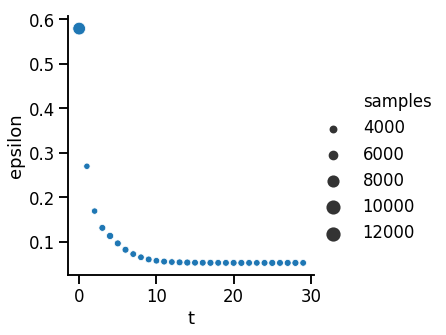

In [23]:
sns.set_context('talk')
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
grid.savefig('results/ik1/eps_evolution.pdf')

In [24]:
df, w = history.get_distribution(m=0)

/Users/charles/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


/Users/charles/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()


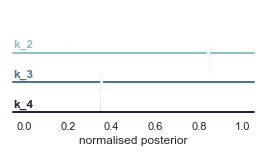

In [43]:
g = plot_parameters_kde(df, w, limits, aspect=5, height=0.8)
g.savefig('results/ik1/parameters_kde.pdf')

# Samples for quantitative analysis

In [26]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

/Users/charles/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [27]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

/Users/charles/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


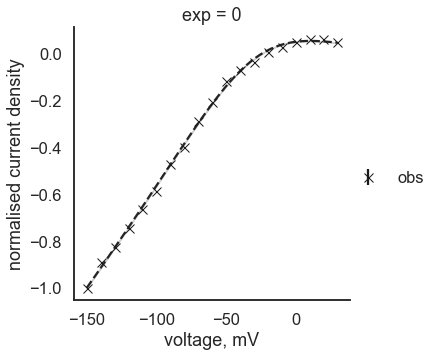

In [35]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV"]
ylabels = ["normalised current density"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [36]:
g.savefig('results/ik1/ik1_sim_results.pdf')